In [1]:
# import packages
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# load data into workspace
dateparse = lambda dates: pd.datetime.strptime(dates + '-0', "%Y%W-%w")
sale = pd.read_csv('sales small.csv', parse_dates=['sales_small.WeekKey'],
                   date_parser=dateparse)

price_change = pd.read_csv('price changes.csv', parse_dates=['price_changes.WeekKey'],
                   date_parser=dateparse)

# no date time, no need to parse it
product = pd.read_csv('products.csv')

## 1. Forecasting weekly sales volumes based on historic transactional data.

### 1.1 Data preprocessing for time series forecasting

In [3]:
# aggregate total sales volume on date, channels and countries
ts = sale.groupby(['sales_small.WeekKey','sales_small.Channel', 
                   'sales_small.Country']).agg({'sales_small.SalesVolume': np.sum})

In [4]:
# reset the index
ts.reset_index(inplace = True)

In [5]:
# select possible four sale's volumes to conduct further forecasting analysis
# country-A, channel-online
ts_online_A = ts.loc[(ts['sales_small.Channel'] == 'Online') & (ts['sales_small.Country'] == 'A')]
print(ts_online_A.shape)
# country-B, channel-online
ts_online_B = ts.loc[(ts['sales_small.Channel'] == 'Online') & (ts['sales_small.Country'] == 'B')]
print(ts_online_B.shape)
ts_online_B.columns = ['sales_small.WeekKey', 'sales_small.Channel', 'sales_small.Country', 'online_B_sales']
# country-A, channel-stores
ts_stores_A = ts.loc[(ts['sales_small.Channel'] == 'Stores') & (ts['sales_small.Country'] == 'A')]
print(ts_stores_A.shape)
ts_stores_A.columns = ['sales_small.WeekKey', 'sales_small.Channel', 'sales_small.Country', 'stores_A_sales']
# country-B, channel-stores
ts_stores_B = ts.loc[(ts['sales_small.Channel'] == 'Stores') & (ts['sales_small.Country'] == 'B')]
print(ts_stores_B.shape)
ts_stores_B.columns = ['sales_small.WeekKey', 'sales_small.Channel', 'sales_small.Country', 'stores_B_sales']

(0, 4)
(60, 4)
(60, 4)
(60, 4)


* I can definitely dive into further segmentations such as groups, subgroups, class, and subclasses. However, due to the time constraint, I decided to forecast the above levels

In [6]:
# manipulate the data into the format for modelling purpose
ts_final = ts_stores_A.merge(ts_stores_B[['sales_small.WeekKey','stores_B_sales']], 
                  on=['sales_small.WeekKey']).merge(ts_online_B[['sales_small.WeekKey','online_B_sales']],
                                                on=['sales_small.WeekKey']).drop(['sales_small.Channel', 
                                                                                 'sales_small.Country'],axis = 1)


In [7]:
# create a new feature, contains the overall sale's volumes over time
ts_final['total_SalesVolume'] = ts_final[['stores_A_sales', 'stores_B_sales', 'online_B_sales']].sum(axis = 1)
# set the date as index for modelling purpose
ts_final = ts_final.set_index('sales_small.WeekKey')

In [8]:
# display the result to have a overview
ts_final.head()

,stores_A_sales,stores_B_sales,online_B_sales,total_SalesVolume
sales_small.WeekKey,,,,
2015-01-18,55,344,45,444
2015-01-25,129,1190,132,1451
2015-02-01,198,2150,208,2556
2015-02-08,306,3177,279,3762
2015-02-15,362,4137,384,4883


Text(0,0.5,"Sale's volumes")

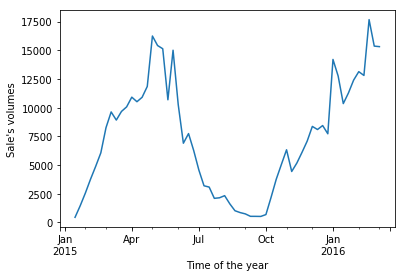

In [9]:
# visualise teh total sale's volume
ts_final['total_SalesVolume'].plot()
# label x and y axis
plt.xlabel('Time of the year', fontsize=10);
plt.ylabel("Sale's volumes", fontsize=10)

### 1.2 Model's diagonosis

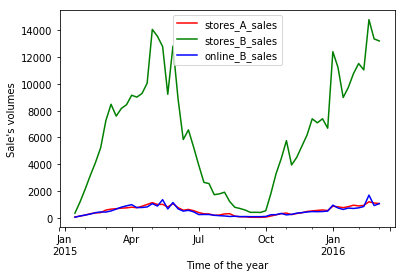

In [10]:
# visualise the time-series data
ts_final.drop(['total_SalesVolume'], axis =1).plot(color=['red', 'green', 'blue'])
plt.xlabel('Time of the year', fontsize=10);
plt.ylabel("Sale's volumes", fontsize=10)
plt.legend(loc="best", labels=['stores_A_sales', 'stores_B_sales', 'online_B_sales'])

* From the plot above, there seems to have a strong seasonal pattern

#### Augmented Dickey-Fuller test

In [11]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(ts_final['total_SalesVolume'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Test Statistic                 -1.409699
p-value                         0.577618
#Lags Used                      0.000000
Number of Observations Used    59.000000
dtype: float64

* p-value > 0.05: We fail to reject the null hypothesis, the data has a unit root and is non-stationary and does have time-dependent structure, so we need to transform(ie: log, diff) the data into stationary series in order to conduct time-series analysis

In [12]:
# take the difference of the time-series
total_sales_diff = ts_final['total_SalesVolume'].diff(periods = 1).values[1:]

In [13]:
# conduct the stationarity test again
dftest = adfuller(total_sales_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Test Statistic                -8.778715e+00
p-value                        2.409118e-14
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
dtype: float64

* The p-value is much less than 0.05,  so the time-series is stationary now

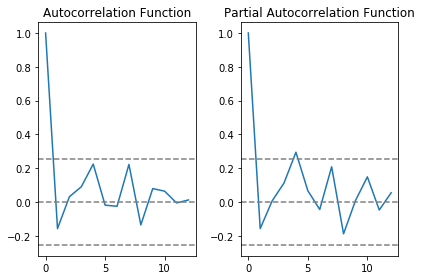

In [14]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(total_sales_diff, nlags=12)
lag_pacf = pacf(total_sales_diff, nlags=12, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(total_sales_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(total_sales_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(total_sales_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(total_sales_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

* Identify p from PACF, and q from acf

* above graphs give us a great ideas how the model would look like

#### Decomposition analysis

Decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns.

* trend
* seasonal
* residual

additive model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time 

* y(t) = Level + Trend + Seasonality + Noise

A multiplicative model is more appropriate when we are increasing (or decreasing) at a non-linear rate 
* y(t) = Level * Trend * Seasonality * Noise

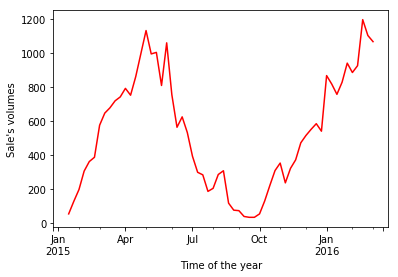

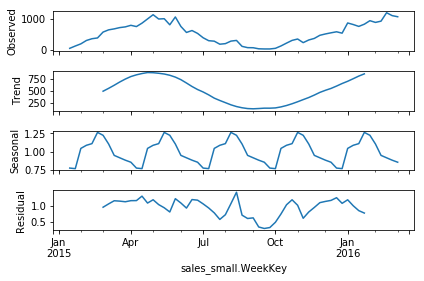

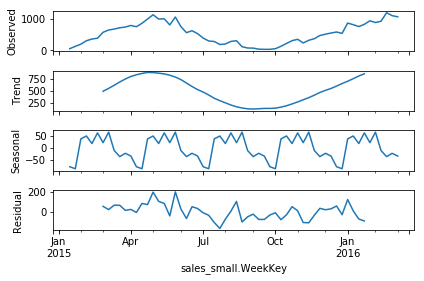

In [15]:
stores_A_sales = ts_final['stores_A_sales']

ts_final['stores_A_sales'].plot(color=['red'])
plt.xlabel('Time of the year', fontsize=10);
plt.ylabel("Sale's volumes", fontsize=10)

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(stores_A_sales, model="multiplicative", freq=12)
fig = result.plot()

result = seasonal_decompose(stores_A_sales, model="additive", freq=12)
fig = result.plot()

* Country - B, Channel - Stores

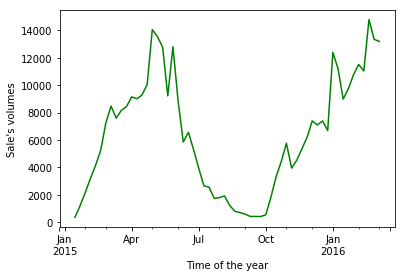

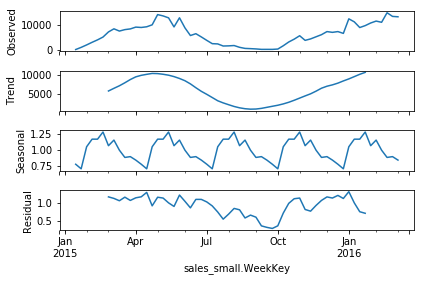

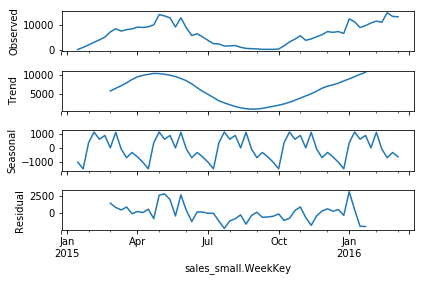

In [16]:
stores_B_sales = ts_final['stores_B_sales']

ts_final['stores_B_sales'].plot(color=['green'])
plt.xlabel('Time of the year', fontsize=10);
plt.ylabel("Sale's volumes", fontsize=10)

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(stores_B_sales, model="multiplicative", freq=12)
fig = result.plot()

result = seasonal_decompose(stores_B_sales, model="additive", freq=12)
fig = result.plot()

* Country - B, Channel - Online

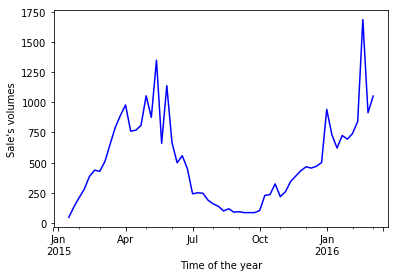

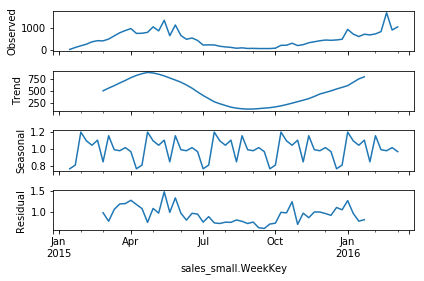

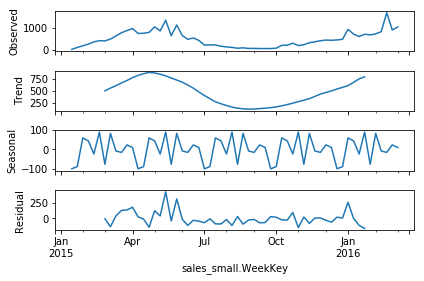

In [17]:
online_B_sales = ts_final['online_B_sales']

ts_final['online_B_sales'].plot(color=['blue'])
plt.xlabel('Time of the year', fontsize=10);
plt.ylabel("Sale's volumes", fontsize=10)

result = seasonal_decompose(online_B_sales, model="multiplicative", freq=12)
fig = result.plot()

result = seasonal_decompose(online_B_sales, model="additive", freq=12)
fig = result.plot()

- In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

In [18]:
# train test data split
percent = 0.8
split = round(len(stores_A_sales) * percent)

train, test = stores_A_sales[0:split], stores_A_sales[split:]

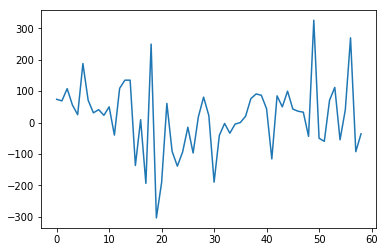

In [19]:
stores_A_sales_diff = stores_A_sales.diff(periods = 1).values[1:]
plt.plot(stores_A_sales_diff)

In [20]:
dftest = adfuller(stores_A_sales_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Test Statistic                -7.919061e+00
p-value                        3.766968e-12
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
dtype: float64

* p-value is much less than 0.05 now, the time series is now stationary

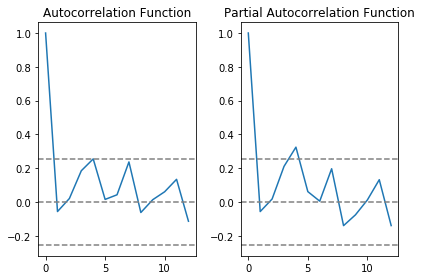

In [21]:
# determine number of p and q
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(stores_A_sales_diff, nlags=12)
lag_pacf = pacf(stores_A_sales_diff, nlags=12, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stores_A_sales_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stores_A_sales_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stores_A_sales_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stores_A_sales_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


* after differencing, it removed seasonality
* Identify p from PACF, and q from acf, there is not lags that are outside the significant level at acf, at period 4, there is significant spike at lage 4 on PACF q could potentially be 4, 
* above graphs give us a great ideas how the model would look like

### 1.3 ARIMA Times series modelling

In [22]:
from pyramid.arima import auto_arima
model = auto_arima(stores_A_sales, start_p=0, start_q=0,
                        #The period for seasonal differencing, m refers to the number of periods in each season.
                           max_p=5, max_q=5, m = 52,
                           start_P=0,seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  ## don't want to know if an order does not work
                           suppress_warnings=True, # don't want convergence warnings
                           stepwise=True) # # set to stepwise based on AIC or etc
print(model.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=94.456, BIC=94.348, Fit time=0.619 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=95.708, BIC=95.546, Fit time=0.499 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.138 seconds
94.45568878354918


In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -45.228
Date:                            Thu, 19 Sep 2019   AIC                             94.456
Time:                                    20:15:16   BIC                             94.348
Sample:                                         0   HQIC                            93.119
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -40.2857     60.270     -0.668      0.504    -158.413      77.842
sigma2      2.397e+04    1.5e+04      1.602      0.109   -5349.491    5.33e+04
===================================================================================
Ljung-Box (Q):                        4.71   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.58   Prob(JB):                         0.92
Heteroskedasticity (H):               7.49   Skew:                             0.30
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
import statsmodels.api as sm
# apply the selected models
stores_A_model = sm.tsa.statespace.SARIMAX(stores_A_sales,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
stores_A_model = stores_A_model.fit()

/Users/zhongjiulu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/Users/zhongjiulu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [25]:
# print statistics
print(stores_A_model.aic)
print(stores_A_model.summary())

92.91463865803331
                                 Statespace Model Results                                 
Dep. Variable:                     stores_A_sales   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -45.457
Date:                            Thu, 19 Sep 2019   AIC                             92.915
Time:                                    20:15:25   BIC                             92.861
Sample:                                01-18-2015   HQIC                            92.246
                                     - 03-06-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.536e+04   1.65e+04      1.539      0.124   -6938.440    5.77e+04
Ljung-Box (Q):   

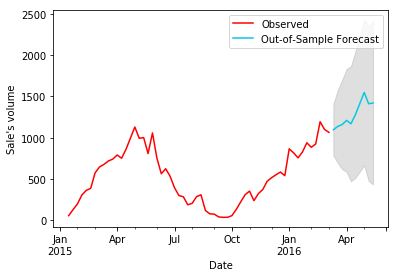

In [26]:
# predict out of sample and find confidence bounds
pred_out = stores_A_model.get_prediction(start=pd.to_datetime('2016-03-13'), 
                              end=pd.to_datetime('2016-05-15'), 
                              dynamic=False, full_results=True)
pred_out_ci = pred_out.conf_int()

ax = stores_A_sales['2015-01-18':].plot(label='Observed', color='red')
pred_out.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast', color='#06c8e2')
ax.fill_between(pred_out_ci.index,
                pred_out_ci.iloc[:, 0],
                pred_out_ci.iloc[:, 1], color='grey', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel("Sale's volume")
plt.legend()
plt.show()


** Country B **

In [27]:
from pyramid.arima import auto_arima
model = auto_arima(stores_B_sales, start_p=0, start_q=0,
                        #The period for seasonal differencing, m refers to the number of periods in each season.
                           max_p=5, max_q=5, m = 52,
                           start_P=0,seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  ## don't want to know if an order does not work
                           suppress_warnings=True, # don't want convergence warnings
                           stepwise=True) # # set to stepwise based on AIC or etc
print(model.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=128.173, BIC=128.065, Fit time=0.078 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=128.501, BIC=128.339, Fit time=0.199 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=131.564, BIC=131.348, Fit time=0.965 seconds
Total fit time: 1.261 seconds
128.17285553909647


In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -62.086
Date:                            Thu, 19 Sep 2019   AIC                            128.173
Time:                                    20:15:29   BIC                            128.065
Sample:                                         0   HQIC                           126.836
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -557.8571    658.890     -0.847      0.397   -1849.257     733.543
sigma2      2.961e+06   1.66e+06      1.787      0.074   -2.87e+05    6.21e+06
===================================================================================
Ljung-Box (Q):                        2.58   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.86   Prob(JB):                         0.97
Heteroskedasticity (H):              14.70   Skew:                             0.22
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
stores_B_sales_model = sm.tsa.statespace.SARIMAX(stores_B_sales,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
stores_B_sales_model = stores_B_sales_model.fit()

/Users/zhongjiulu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/Users/zhongjiulu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [30]:
# print statistics
print(stores_B_sales_model.aic)
print(stores_B_sales_model.summary())

126.88742542721903
                                 Statespace Model Results                                 
Dep. Variable:                     stores_B_sales   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -62.444
Date:                            Thu, 19 Sep 2019   AIC                            126.887
Time:                                    20:15:30   BIC                            126.833
Sample:                                01-18-2015   HQIC                           126.219
                                     - 03-06-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.067e+06   1.69e+06      1.812      0.070    -2.5e+05    6.38e+06
Ljung-Box (Q):  

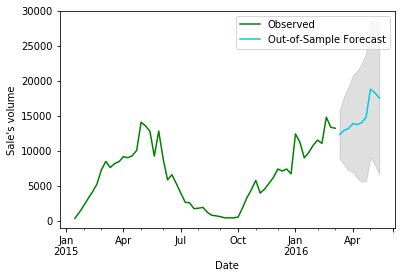

In [31]:
# predict out of sample and find confidence bounds
pred_out = stores_B_sales_model.get_prediction(start=pd.to_datetime('2016-03-13'), 
                              end=pd.to_datetime('2016-05-15'), 
                              dynamic=False, full_results=True)
pred_out_ci = pred_out.conf_int()

ax = stores_B_sales['2015-01-18':].plot(label='Observed', color='green')
pred_out.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast', color='#06c8e2')
ax.fill_between(pred_out_ci.index,
                pred_out_ci.iloc[:, 0],
                pred_out_ci.iloc[:, 1], color='grey', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel("Sale's volume")
plt.legend()
plt.show()

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -62.086
Date:                            Thu, 19 Sep 2019   AIC                            128.173
Time:                                    20:15:31   BIC                            128.065
Sample:                                         0   HQIC                           126.836
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -557.8571    658.890     -0.847      0.397   -1849.257     733.543
sigma2      2.961e+06   1.66e+06      1.787      0.074   -2.87e+05    6.21e+06
===================================================================================
Ljung-Box (Q):                        2.58   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.86   Prob(JB):                         0.97
Heteroskedasticity (H):              14.70   Skew:                             0.22
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
from pyramid.arima import auto_arima
model = auto_arima(online_B_sales, start_p=0, start_q=0,
                        #The period for seasonal differencing, m refers to the number of periods in each season.
                           max_p=5, max_q=5, m = 52,
                           start_P=0,seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  ## don't want to know if an order does not work
                           suppress_warnings=True, # don't want convergence warnings
                           stepwise=True) # # set to stepwise based on AIC or etc
print(model.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=108.389, BIC=108.281, Fit time=0.096 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=108.284, BIC=108.122, Fit time=0.407 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1,

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -51.142
Date:                            Thu, 19 Sep 2019   AIC                            108.284
Time:                                    20:15:35   BIC                            108.122
Sample:                                         0   HQIC                           106.279
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -14.5694    248.165     -0.059      0.953    -500.964     471.825
ar.L1         -0.4857      0.358     -1.355      0.175      -1.188       0.217
sigma2      1.269e+05   1.02e+05      1.241      0.215   -7.35e+04    3.27e+05
===================================================================================
Ljung-Box (Q):                        2.02   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.92   Prob(JB):                         0.27
Heteroskedasticity (H):              30.21   Skew:                             1.41
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
online_B_sales_model = sm.tsa.statespace.SARIMAX(online_B_sales,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 0, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
online_B_sales_model = online_B_sales_model.fit()

/Users/zhongjiulu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [36]:
# print statistics
print(online_B_sales_model.aic)
print(online_B_sales_model.summary())

106.29280458844161
                                 Statespace Model Results                                 
Dep. Variable:                     online_B_sales   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -51.146
Date:                            Thu, 19 Sep 2019   AIC                            106.293
Time:                                    20:15:38   BIC                            106.185
Sample:                                01-18-2015   HQIC                           104.956
                                     - 03-06-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4847      0.328     -1.477      0.140      -1.128       0.159
sigma2      1.27

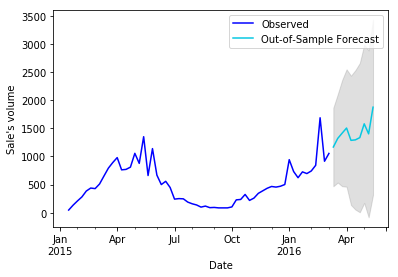

In [37]:
# predict out of sample and find confidence bounds
pred_out = online_B_sales_model.get_prediction(start=pd.to_datetime('2016-03-13'), 
                              end=pd.to_datetime('2016-05-15'), 
                              dynamic=False, full_results=True)
pred_out_ci = pred_out.conf_int()

ax = online_B_sales['2015-01-18':].plot(label='Observed', color='blue')
pred_out.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast', color='#06c8e2')
ax.fill_between(pred_out_ci.index,
                pred_out_ci.iloc[:, 0],
                pred_out_ci.iloc[:, 1], color='grey', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel("Sale's volume")
plt.legend()
plt.show()

## 2. Price elasticity Analysis

### 2.1 Price Elasticity of Demand

In [38]:
# reload the dataset into workplace to avoid confusion
dateparse = lambda dates: pd.datetime.strptime(dates + '-0', "%Y%W-%w")
sale = pd.read_csv('sales small.csv', parse_dates=['sales_small.WeekKey'],
                   date_parser=dateparse)

price_change = pd.read_csv('price changes.csv', parse_dates=['price_changes.WeekKey'],
                   date_parser=dateparse)

# no date time, no need to parse it
product = pd.read_csv('products.csv')

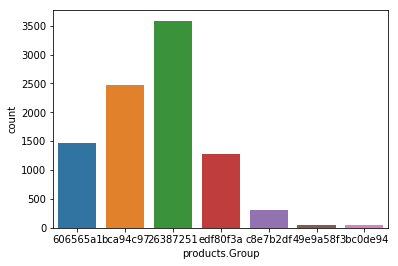

In [41]:
# see the group distribution
sns.countplot(x=product['products.Group'], data=product)

In [42]:
# merge to obtain a master dataset
df = pd.merge(sale, price_change,how = "left", left_on = ["sales_small.ProductID","sales_small.WeekKey",
                                                             "sales_small.Channel","sales_small.Country"],
                right_on =[ "price_changes.ProductID","price_changes.WeekKey",
                           "price_changes.Channel","price_changes.Country"])

# merge the product type
df = pd.merge(df, product, how = "left", left_on = "sales_small.ProductID", right_on = "products.ProductID")

In [43]:
# define the selected columns
col = ['sales_small.ProductID',
 'sales_small.Channel',
 'sales_small.Country',
 'sales_small.WeekKey',
 'sales_small.CSP',
 'sales_small.SalesVolume',
 'price_changes.OSP',
 'price_changes.previous_CSP',
 'price_changes.CSP',
 'products.Group',
 'products.SubGroup']
# subset the selected columns
df = df[col]

In [44]:
# define precious week using datetime 
df['Previous_week'] = df['sales_small.WeekKey'] - np.timedelta64(1,'W')

In [45]:
# join itself to obtain price change and volume change
df_final = pd.merge(df, df, how = "left", 
                              left_on = ["sales_small.ProductID","Previous_week",
                                        "sales_small.Channel","sales_small.Country"],
                right_on =["sales_small.ProductID","sales_small.WeekKey",
                           "sales_small.Channel","sales_small.Country"])

In [46]:
# create feature to test whether there is a present of price change
df_final['price_change'] = df_final['sales_small.CSP_x'] - df_final['sales_small.CSP_y']

In [47]:
# filter out observations that does not have a price change
df_final = df_final[(df_final['price_change'] != 0)]
# drop nan values in price_change, observations do not have price change
df_final = df_final.dropna(subset=['price_change'])

In [48]:
# define columns to be used for further anlaysis
col = ['sales_small.ProductID', 'sales_small.Channel', 'sales_small.Country',
       'sales_small.WeekKey_x', 'sales_small.CSP_x', 'sales_small.SalesVolume_x',
      'products.Group_x', 'products.SubGroup_x', 'sales_small.CSP_y',
       'sales_small.SalesVolume_y']

In [49]:
# select subset the dataset
df_final = df_final[col]

In [50]:
# create new feature, product price elasticity - % change in quantity / % change in price
df_final['elasticity'] = ((df_final['sales_small.SalesVolume_x'] - df_final['sales_small.SalesVolume_y']
                         )/df_final['sales_small.SalesVolume_y']
                         )/((df_final['sales_small.CSP_x'] - df_final['sales_small.CSP_y']
                            )/df_final['sales_small.CSP_y'])

In [51]:
df_final.head()

,sales_small.ProductID,sales_small.Channel,sales_small.Country,sales_small.WeekKey_x,sales_small.CSP_x,sales_small.SalesVolume_x,products.Group_x,products.SubGroup_x,sales_small.CSP_y,sales_small.SalesVolume_y,elasticity
950,135fc45e,Stores,B,2015-02-22,16.283,13,26387251,c3567a18,18.984,4.0,-15.814143
1000,3b325781,Online,B,2015-02-22,16.733,5,26387251,14edd834,21.234,3.0,-3.145079
1019,429309b,Stores,A,2015-02-22,13.493,2,c8e7b2df,c8e7b2df,15.833,0.0,-inf
1020,431eec16,Online,B,2015-02-22,14.483,3,26387251,c3567a18,18.084,2.0,-2.510969
1022,44d4fa38,Stores,B,2015-02-22,12.232,2,c8e7b2df,c8e7b2df,13.583,0.0,-inf


In [52]:
# check the differnet values in the created new feature - price elasticity
df_final['elasticity'].value_counts().head()

-0.000000     566
-inf          117
 inf           10
-13.591111      7
-5.027017       6
Name: elasticity, dtype: int64

In [53]:
# check the pattern of nan value in elasticity
df_final[df_final['elasticity'].isna()].head()

,sales_small.ProductID,sales_small.Channel,sales_small.Country,sales_small.WeekKey_x,sales_small.CSP_x,sales_small.SalesVolume_x,products.Group_x,products.SubGroup_x,sales_small.CSP_y,sales_small.SalesVolume_y,elasticity
3374,431eec16,Stores,A,2015-03-29,13.430,0,26387251,c3567a18,14.582,0.0,NaN
5979,429309b,Stores,A,2015-04-26,12.322,0,c8e7b2df,c8e7b2df,13.493,0.0,NaN
6023,52bfaadb,Stores,B,2015-04-26,12.232,0,606565a1,9d3d7fe0,13.358,0.0,NaN
6199,8758a09,Stores,A,2015-04-26,12.885,0,bca94c97,c830b21c,17.408,0.0,NaN
6422,cfdace13,Stores,A,2015-04-26,12.232,0,bca94c97,c830b21c,14.483,0.0,NaN


* find out the fact that the change in price does not have an significant impact on sales volume.
* these product are in general very inelastic, since I do not want to miss the  observations. The art side of science for me is to replace it with value 0
* in terms of busienss content, these products are just not demanding in the market, which leads to no sales

In [54]:
#fill na equal to 0, since their volume does not change no matter what price is set. super inelastic
df_final = df_final.fillna(0)
# it is hard to compare inf and -inf observations, and will ruin the overall data. i decided to remove it
df_final = df_final.replace([np.inf, -np.inf], np.nan).dropna()

In [55]:
# check the number of observations in the cleaned data
df_final.shape

(2513, 11)

In [56]:
# I aggregate the data into group and countries with the mean value of elasticity
cate_country_ela = df_final.groupby(['products.Group_x', 'sales_small.Country']
                               ).agg({'elasticity': np.mean})
cate_country_ela.reset_index(inplace = True)
cate_country_ela

,products.Group_x,sales_small.Country,elasticity
0,26387251,A,-3.377693
1,26387251,B,-7.597680
2,3bc0de94,B,-3.465628
3,49e9a58f,B,-10.405219
4,606565a1,A,-1.964153
5,606565a1,B,-13.586743
6,bca94c97,A,-1.943494
7,bca94c97,B,-5.598405
8,c8e7b2df,A,-3.776165
9,c8e7b2df,B,-11.595846


Text(0,0.5,'Groups')

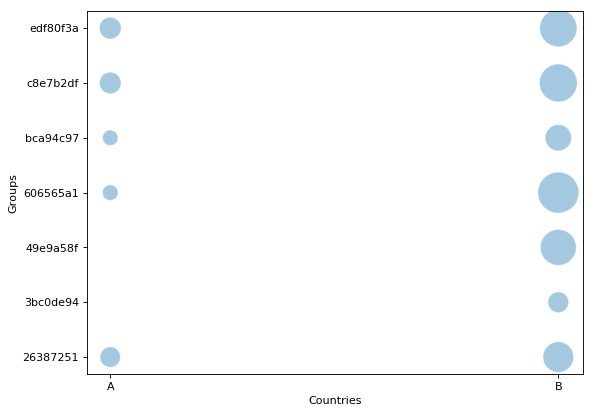

In [57]:
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(cate_country_ela['sales_small.Country'], cate_country_ela['products.Group_x'], 
            s=cate_country_ela['elasticity']*(-100), 
            alpha=0.4, edgecolors='w')

plt.xlabel('Countries')
plt.ylabel('Groups')
# plt.title('Wine Alcohol Content - Fixed Acidity - Residual Sugar',y=1.05)

In [58]:
cate_channel_ela = df_final.groupby(['products.Group_x', 'sales_small.Channel']
                               ).agg({'elasticity': np.mean})
cate_channel_ela.reset_index(inplace = True)
cate_channel_ela

,products.Group_x,sales_small.Channel,elasticity
0,26387251,Online,-7.529180
1,26387251,Stores,-5.839701
2,3bc0de94,Online,-3.465628
3,49e9a58f,Online,-13.006524
4,49e9a58f,Stores,0.000000
5,606565a1,Online,-21.294520
6,606565a1,Stores,-6.012278
7,bca94c97,Online,-7.710534
8,bca94c97,Stores,-3.024274
9,c8e7b2df,Online,-17.168781


Text(0,0.5,'Groups')

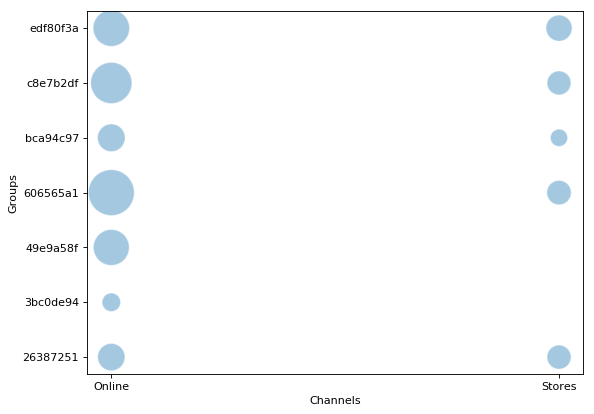

In [59]:
# set up the figure size
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(cate_channel_ela['sales_small.Channel'], cate_channel_ela['products.Group_x'], 
            s=cate_channel_ela['elasticity']*(-80), 
            alpha=0.4, edgecolors='w')

plt.xlabel('Channels')
plt.ylabel('Groups')

In [60]:
country_channel_ela = df_final.groupby(['sales_small.Country', 'sales_small.Channel']
                               ).agg({'elasticity': np.mean})
country_channel_ela.reset_index(inplace = True)
country_channel_ela

,sales_small.Country,sales_small.Channel,elasticity
0,A,Stores,-2.854687
1,B,Online,-9.531849
2,B,Stores,-6.789624


Text(0,0.5,'Countries')

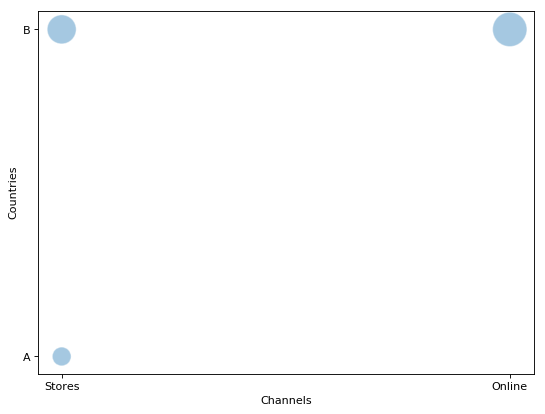

In [61]:
# set up the figure size
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(country_channel_ela['sales_small.Channel'], country_channel_ela['sales_small.Country'], 
            s=country_channel_ela['elasticity']*(-100), 
            alpha=0.4, edgecolors='w')

plt.xlabel('Channels')
plt.ylabel('Countries')

In [64]:
# visualise it in a four dimensional space, see whether it works well
four_dim = df_final.groupby(['sales_small.Country', 'sales_small.Channel','products.Group_x']
                               ).agg({'elasticity': np.mean})
four_dim.reset_index(inplace = True)

Text(0.5,0.98,'Country - Channel - Group - Elasticity')

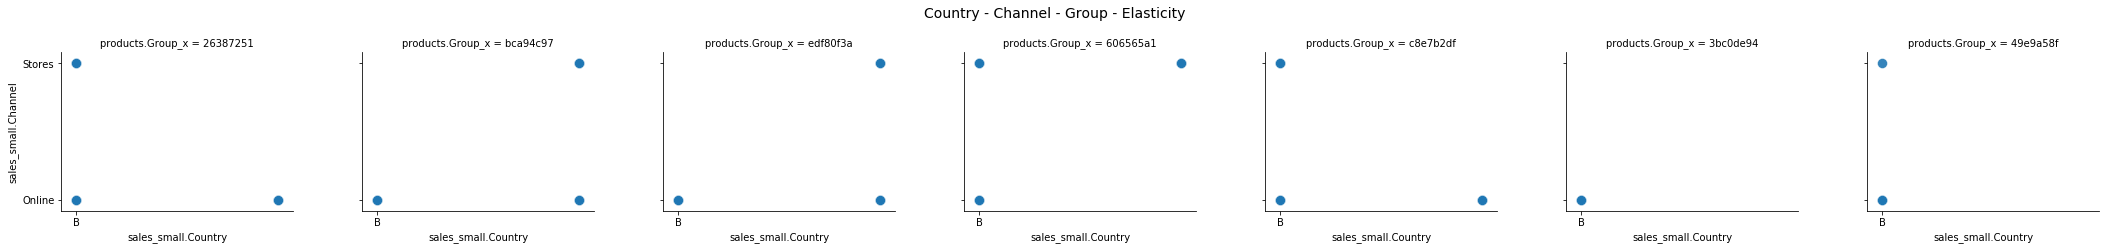

In [65]:
# perform the visualisation trick here
g = sns.FacetGrid(df_final, col="products.Group_x",
                  aspect=1.2, size=3.5, palette=sns.light_palette('navy', 4)[1:])
g.map(plt.scatter, "sales_small.Country", "sales_small.Channel", alpha=0.9, 
      edgecolor='white', linewidth=0.5, s=100)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Country - Channel - Group - Elasticity', fontsize=14)
# l = g.add_legend(title='Wine Quality Class')

## To be continued ......

## 2.2 Alternative Regression Approach

* Log-Log Model

* some value errors need to be fixed. the idea is to average their co-efficient(price elasticity), which is the group elasticity in country - b, channel store. After this, we can write another loop to obtain other countries and channels price elasticities

* if the above is sucessfully implimented, we can obtain the similar plots as above with regression methodology rather than simple mathematical formular. This approach enables to control other factors such as seasonal effect and etc

* Further analysis can be implimented

## 2.3 Cross-Price Elasticity

Cross-Price Elasticity Example

* Competitor j lowers price by 10 percent, our volume declines by 5 percent The cross-price elasticity of our sales with respect to competitor j’s price is 5/10 = 0.50

* Interpretation: if our competitor increases price by 1% we will increase our units sold by 0.5%

** Elasticity Matrices **

* Cross-Price Elasticity of a product type with respect to a price change by the another product type and on the off-diagonal cells are the Own-Price Elasticity.

## 2.4 Clout and Vulnerability

* Clout - Sum of pricing effects of brand i on competitors
* Vulnerability - Sum of competitors’ effects on brand i